In [212]:
import numpy as np

import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import operation

# Cutoff dimension
cutoff = 9

# Number of layers
depth = 15

# Number of steps in optimization routine performing gradient descent
#reps = 200
reps = 2

# Learning rate
lr = 0.05

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

In [213]:
# Matthieu's comment: in our case of two QDOs, we need a two-mode circuit
# the shape of the parameter will therefore rather be (depth, 2)

import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# squeeze gate
sq_r = tf.random.normal(shape=[depth], stddev=active_sd)
sq_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# displacement gate
d_r = tf.random.normal(shape=[depth], stddev=active_sd)
d_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# rotation gates
r1 = tf.random.normal(shape=[depth], stddev=passive_sd)
r2 = tf.random.normal(shape=[depth], stddev=passive_sd)


# Matthieu's comment: do we need this non-Gaussian gate in the case of a quadratic
# dipole-dipole interaction? Probably not. It would become relevant for higher
# multipolar interactions I think
# kerr gate
kappa = tf.random.normal(shape=[depth], stddev=active_sd)

In [214]:
weights = tf.convert_to_tensor([r1, sq_r, sq_phi, r2, d_r, d_phi, kappa])
weights = tf.Variable(tf.transpose(weights))

In [ ]:
weights

Since we have a depth of 15 (so 15 layers), and each layer takes
7 different types of parameters, the final shape of our weights
array should be $\text{depth}\times 7$ or ``(15, 7)``:



In [ ]:
print(weights.shape)

In [ ]:
# Single-mode Strawberry Fields program
prog = sf.Program(1)

# Create the 7 Strawberry Fields free parameters for each layer
sf_params = []
names = ["r1", "sq_r", "sq_phi", "r2", "d_r", "d_phi", "kappa"]

for i in range(depth):
    # For the ith layer, generate parameter names "r1_i", "sq_r_i", etc.
    sf_params_names = ["{}_{}".format(n, i) for n in names]
    # Create the parameters, and append them to our list ``sf_params``.
    sf_params.append(prog.params(*sf_params_names))

``sf_params`` is now a nested list of shape ``(depth, 7)``, matching
the shape of ``weights``.



In [ ]:
sf_params = np.array(sf_params)
print(sf_params.shape)

Now, we can create a function to define the $i$\ th layer, acting on qumode ``q``. We add
the :class:`~strawberryfields.utils.operation` decorator so that the layer can be used as a single
operation when constructing our circuit within the usual Strawberry Fields Program context



In [ ]:
# layer architecture
@operation(1)
def layer(i, q):
    Rgate(sf_params[i][0]) | q
    Sgate(sf_params[i][1], sf_params[i][2]) | q
    Rgate(sf_params[i][3]) | q
    Dgate(sf_params[i][4], sf_params[i][5]) | q
    Kgate(sf_params[i][6]) | q
    return q

Now that we have defined our gate parameters and our layer structure, we
can construct our variational quantum circuit.



In [ ]:
# Apply circuit of layers with corresponding depth
with prog.context as q:
    for k in range(depth):
        layer(k) | q[0]
    #MeasureFock() | q[0]
    #MeasureHomodyne(phi=0.0) | q[0]

In [ ]:
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})

In [ ]:
mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

# Run engine
results = eng.run(prog, args=mapping, shots=1)

In [ ]:
def cost(weights):
    # Create a dictionary mapping from the names of the Strawberry Fields
    # free parameters to the TensorFlow weight values.
    mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

    # Run engine
    results = eng.run(prog, args=mapping)
    #photon_number = tf.cast(results.samples[0][0], dtype=tf.float32)
    state = results.state
    x = state.quad_expectation(mode=0, phi=0.0)[0] # returns both the expectation value and variance of the position quadrature.
    p = state.quad_expectation(mode=0, phi=0.5*np.pi)[0] # returns both the expectation value and variance of the position quadrature.

    # Objective function to minimize
    #cost = photon_number + 0.5
    #cost = photon_number
    return 0.5 * (x**2 + p**2)

In [ ]:
cost(weights)

Now that the cost function is defined, we can define and run the
optimization. Below, we choose the Adam
optimizer that is built into TensorFlow:



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)

We then loop over all repetitions, storing the best predicted fidelity
value.



In [209]:
loss_progress = []
best_loss = float('inf')

for i in range(reps):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss = cost(weights)

    loss_progress.append(loss.numpy())

    if loss < best_loss:
        best_loss = loss.numpy()

    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Prints progress at every rep
    if i % 1 == 0:
        print("Rep: {} Cost: {:.20f}".format(i, loss))

Rep: 0 Cost: 0.00000000022092427887
Rep: 1 Cost: 0.00000000002382671838
Rep: 2 Cost: 0.00000000011886669427
Rep: 3 Cost: 0.00000000010917711180
Rep: 4 Cost: 0.00000000007684963776
Rep: 5 Cost: 0.00000000003781919222
Rep: 6 Cost: 0.00000000010662415395
Rep: 7 Cost: 0.00000000006393163776
Rep: 8 Cost: 0.00000000001240696434
Rep: 9 Cost: 0.00000000010076661727
Rep: 10 Cost: 0.00000000002494582318
Rep: 11 Cost: 0.00000000003107214486
Rep: 12 Cost: 0.00000000005508882239
Rep: 13 Cost: 0.00000000002560973655
Rep: 14 Cost: 0.00000000002131983479
Rep: 15 Cost: 0.00000000002686073586
Rep: 16 Cost: 0.00000000003082778477
Rep: 17 Cost: 0.00000000000259137156
Rep: 18 Cost: 0.00000000002731015414
Rep: 19 Cost: 0.00000000002256683729
Rep: 20 Cost: 0.00000000000089184216
Rep: 21 Cost: 0.00000000002822464484
Rep: 22 Cost: 0.00000000001302602470
Rep: 23 Cost: 0.00000000000495425923
Rep: 24 Cost: 0.00000000001818600825
Rep: 25 Cost: 0.00000000000724842408
Rep: 26 Cost: 0.00000000000866562377
Rep: 27 Cos

Results and visualisation
-------------------------

Plotting the fidelity vs. optimization step:



Text(0.5, 0, 'Step')

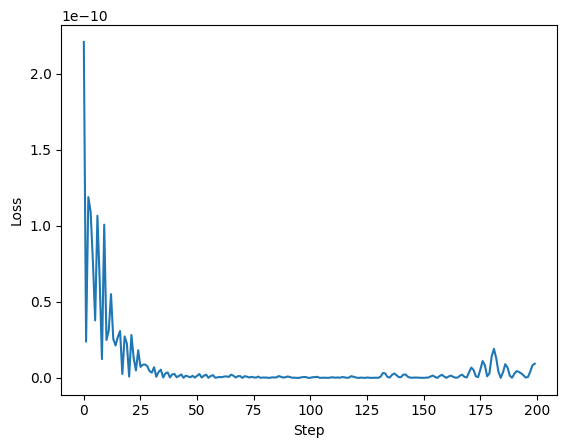

In [210]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
plt.style.use("default")

plt.plot(loss_progress)
plt.ylabel("Loss")
plt.xlabel("Step")

We can use the following function to plot the Wigner function of our
target and learnt state:



In [211]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Computing the density matrices
$\rho = \left|\psi\right\rangle \left\langle\psi\right|$ of the
target and learnt state,



In [ ]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

Plotting the Wigner function of the target state:



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

Plotting the Wigner function of the learnt state:



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

References
----------

1. Juan Miguel Arrazola, Thomas R. Bromley, Josh Izaac, Casey R. Myers,
   Kamil Brádler, and Nathan Killoran. Machine learning method for state
   preparation and gate synthesis on photonic quantum computers. `Quantum
   Science and Technology, 4
   024004 <https://iopscience.iop.org/article/10.1088/2058-9565/aaf59e>`__,
   (2019).

2. Nathan Killoran, Thomas R. Bromley, Juan Miguel Arrazola, Maria Schuld,
   Nicolas Quesada, and Seth Lloyd. Continuous-variable quantum neural networks.
   `Physical Review Research, 1(3), 033063.
   <https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063>`__,
   (2019).

